In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Boosting
## AdaBoost implementation

### Generate synthetic data for testing

In [452]:
num_outside = 200
num_inside = 100
mean_radius_outside = 5
sigma_radius_outside = 1.0
#mean_radius_inside = 1
sigma_radius_inside = 2

theta = np.random.uniform(0,2*np.pi,num_outside)
radii_outside = np.random.normal(mean_radius_outside,sigma_radius_outside,num_outside)

X = np.zeros([num_outside+num_inside,2])
X[:num_outside,0] = np.cos(theta)*radii_outside
X[:num_outside,1] = np.sin(theta)*radii_outside
X[num_outside:,:] = np.random.normal(0,sigma_radius_inside,[num_inside,2])
y = np.ones([num_outside+num_inside])
y[num_outside:] = -1
X.shape,y.shape

((300, 2), (300,))

In [438]:
# This is another synthetic dataset (square)
#X = np.random.uniform(-2,2,(200,2))
#y = np.ones(200)
#y[(X[:,0] > -1) & (X[:,0] < 1.5) & (X[:,1] > -1) & (X[:,1] < 1)] = -1
#y

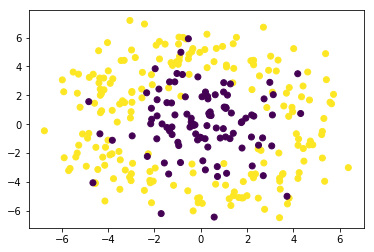

In [453]:
plt.scatter(X[:,0],X[:,1], c = y[:])
plt.show()

## Weak learners (decision trees or logistic regressions)

The algorithm has the following steps:

1. Generate uniform weights for each datapoint: $w_i$
2. Fit a weak learner, provide sample weights to the learner
3. Compute weighted error: $err_m = \frac{\sum{w_i*(\hat{y} != y)}}{\sum{w_i}}$
4. Compute coefficient $\alpha_m = log(\frac{1-err_m}{err_m})$
5. Update sample weights according to errors: $w_m = w_m*e^{\alpha_m*(\hat{y} != y)}$
6. Repeat steps 2-5, saving learners and coefficients $\alpha_m$
7. $\hat{y} = \sum_m sign(\hat{y}_m)*\alpha_m$, where $\hat{y}_m$ -- learner's output

In [455]:
learners, errors, alphas, weights = [],[],[],[np.ones(X.shape[0])/X.shape[0]]

# weak learner 1
w_m = weights[-1]
weak_learner = DecisionTreeClassifier(max_depth=1).fit(X,y, sample_weight = w_m)
y_hat = weak_learner.predict(X)

err_m = np.sum(w_m*(y_hat != y).astype(int))/np.sum(w_m) # the weighted error of the weak learner

alpha_m = np.log((1-err_m)/err_m) # coefficients

w_m *= np.exp(alpha_m*(y_hat != y).astype(int))

learners.append(weak_learner)
errors.append(err_m)
alphas.append(alpha_m)
weights.append(w_m)

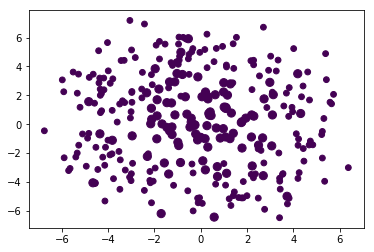

In [456]:
plt.scatter(X[:,0],X[:,1],c = y_hat, s = w_m*10000)
plt.show()

In [457]:
# weak learner 2
w_m = weights[-1]
weak_learner = DecisionTreeClassifier(max_depth=1).fit(X,y, sample_weight = w_m)
weak_learner = LogisticRegression(solver = 'lbfgs').fit(X,y, sample_weight = w_m) # fit a weak learner    
y_hat = weak_learner.predict(X)

err_m = np.sum(w_m*(y_hat != y).astype(int))/np.sum(w_m) # the weighted error of the weak learner

alpha_m = np.log((1-err_m)/err_m) # coefficients

w_m *= np.exp(alpha_m*(y_hat != y).astype(int))

learners.append(weak_learner)
errors.append(err_m)
alphas.append(alpha_m)
weights.append(w_m)

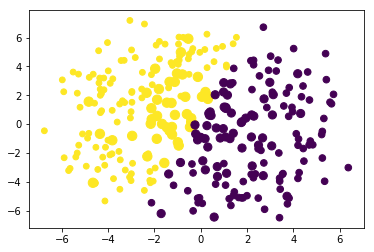

In [460]:
plt.scatter(X[:,0],X[:,1],c = y_hat, s = w_m*10000)
plt.show()

### Looping through multiple learners

The code below will generate multiple weak learners

In [477]:
num_learners = 20
learners, errors, alphas, weights = [],[],[],[np.ones(X.shape[0])/X.shape[0]]
for _ in range(num_learners):
    w_m = weights[-1]
    weak_learner = DecisionTreeClassifier(max_depth=1).fit(X,y, sample_weight = w_m)
    
    y_hat = weak_learner.predict(X)

    err_m = np.sum(w_m*(y_hat != y).astype(int))/np.sum(w_m) # the weighted error of the weak learner

    alpha_m = np.log((1-err_m)/err_m) # coefficients

    w_m *= np.exp(alpha_m*((y_hat != y).astype(int)))

    learners.append(weak_learner)
    errors.append(err_m)
    alphas.append(alpha_m)
    weights.append(w_m.copy())

#weights[0][:5],weights[1][:5]

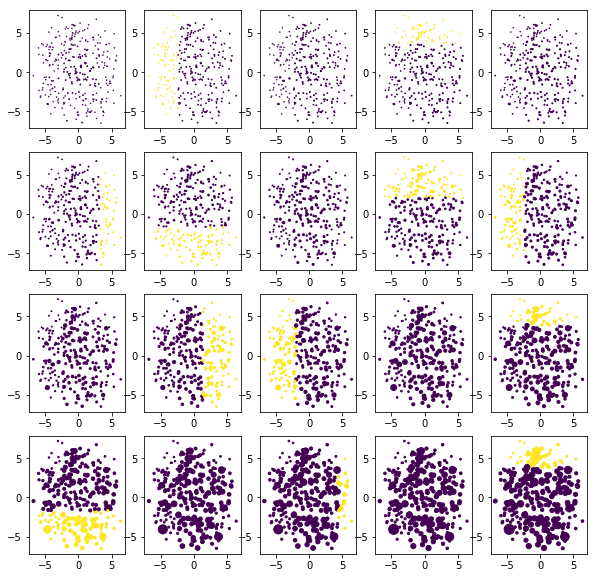

In [482]:
num_cols = 5
plt.figure(figsize = (10,10))
for ix,(learner,weight) in enumerate(zip(learners,weights)):
    ax = plt.subplot(len(learners)//num_cols,num_cols,ix+1)
    y_hat = learner.predict(X)
    ax.scatter(X[:,0],X[:,1], c = y_hat[:], s = weight*100)


### Checking model performance

In [483]:
y_hat = 0
for alpha,learner in zip(alphas,learners):
    y_hat += learner.predict(X)*alpha
y_hat = np.sign(y_hat)

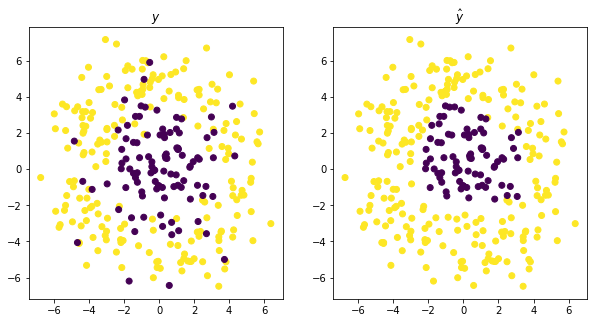

In [484]:
plt.figure(figsize = (10,5))
ax = plt.subplot(1,2,1)
ax.scatter(X[:,0],X[:,1],c = y)
ax.set_title('$y$')
ax = plt.subplot(1,2,2)
ax.scatter(X[:,0],X[:,1],c = y_hat)
ax.set_title('$\hat{y}$')
plt.show()

In [487]:
# Accuracy
np.mean(y_hat == y)

0.9

In [501]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier(n_estimators = 20, base_estimator=DecisionTreeClassifier(max_depth = 1)).fit(X,y)
y_hat2 = ab.predict(X)

In [502]:
#AdaBoostClassifier?

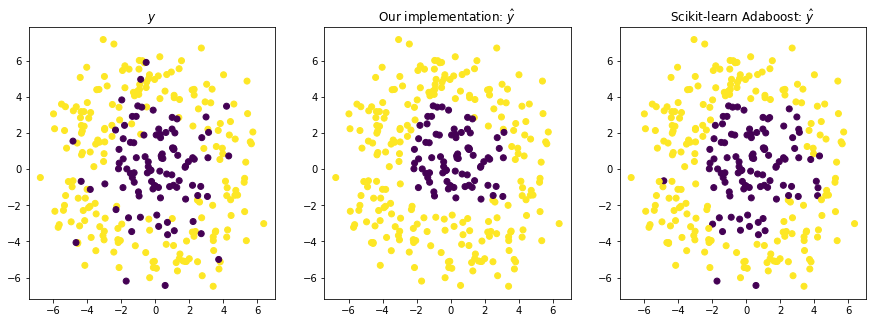

In [503]:
plt.figure(figsize = (15,5))
ax = plt.subplot(1,3,1)
ax.scatter(X[:,0],X[:,1],c = y)
ax.set_title('$y$')
ax = plt.subplot(1,3,2)
ax.scatter(X[:,0],X[:,1],c = y_hat)
ax.set_title('Our implementation: $\hat{y}$')
ax = plt.subplot(1,3,3)
ax.scatter(X[:,0],X[:,1],c = y_hat2)
ax.set_title('Scikit-learn Adaboost: $\hat{y}$')
plt.show()